# WATER BAG INCIDENTS IN RIO DE JANEIRO

### TIME SERIES EXPLORATORY DATA ANALYSIS

### Import modules and functions

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

### Define data class to host data paths
class DATA:
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

### Load data

In [9]:
catalog = pd.read_csv('Dados/water_bag_catalog_google.csv', parse_dates=True, infer_datetime_format=True)

#### Extract records of incidents of water bag formation (copy data for cleaning)

In [10]:
target = "Bolsão d'água em via"

catalog = catalog[catalog['POP_TITULO']==target].copy()

---
### 0. Utility functions

#### Function to format and correct street number text variable

In [11]:
from Modules.text_formatter import text_transform_pipeline, get_not_number, drop_letters, drop_space, drop_chars, split_avg

---
# 1. Data Cleaning

#### Format and correct street number variable

not_number = get_not_number(catalog['street_number'])
not_number_corrected =  text_transform_pipeline(not_number, [drop_letters, drop_space, drop_chars, split_avg])
data.loc[not_number.index, ['street_number']] = not_number_corrected
data.dropna(subset=['street_number'], inplace=True) # drop rows where street number is missing

#### Data type conversion

In [13]:
float_cols = ['EVENTO_LATITUDE', 'EVENTO_LONGITUDE', 'search_lat', 'search_lng']#, 'street_number']

catalog[float_cols] = catalog[float_cols].astype(float)
catalog['EVENTO_INICIO'] = pd.to_datetime(catalog['EVENTO_INICIO'])

---
# 2. Exploratory Data Analysis

In [15]:
ts = catalog.set_index('EVENTO_INICIO')

#### Description

In [16]:
ts.index.to_frame().describe()

,EVENTO_INICIO
count,3140
unique,3077
top,2016-02-22 20:29:00
freq,3
first,2015-09-12 20:12:00
last,2022-04-30 15:33:00


#### Time range

In [17]:
ts.index.max() - ts.index.min()

Timedelta('2421 days 19:21:00')

### Month, Week and Day Time Series

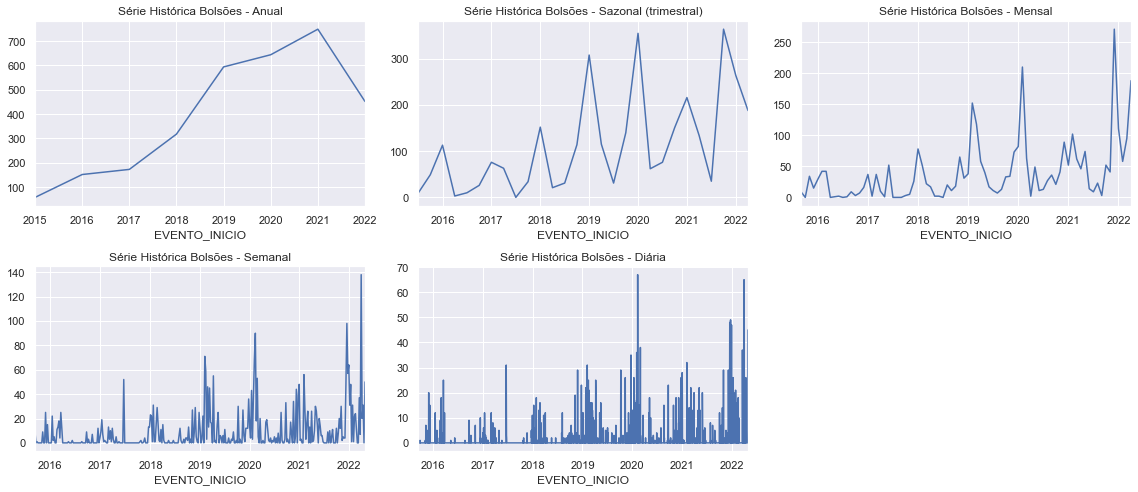

In [18]:
def plot_time_series(ts, id_col, freqs, titles, title, figsize=(16, 7)):

    fig = plt.figure(figsize=figsize, tight_layout=True)
    ax = [fig.add_subplot(2, 3, i) for i in range(1, len(freqs)+1)]
    for i, (freq, name) in enumerate(zip(
        freqs,
        titles
    )):
        ts.resample(freq)[id_col].nunique().plot(ax=ax[i], title=title.format(name))
    plt.show()

freqs = ['Y', 'Q', 'M', 'W', 'D']
titles = ['Anual', 'Sazonal (trimestral)', 'Mensal', 'Semanal', 'Diária']
title = 'Série Histórica Bolsões - {}'

plot_time_series(ts, 'EVENTO_ID', freqs, titles, title)

Obs:
* Seasonal, monthly and weekly time series show great potential for time series prediction, for example how many water bag incidents are expected in the city each month

### Month, Week and Day Averages

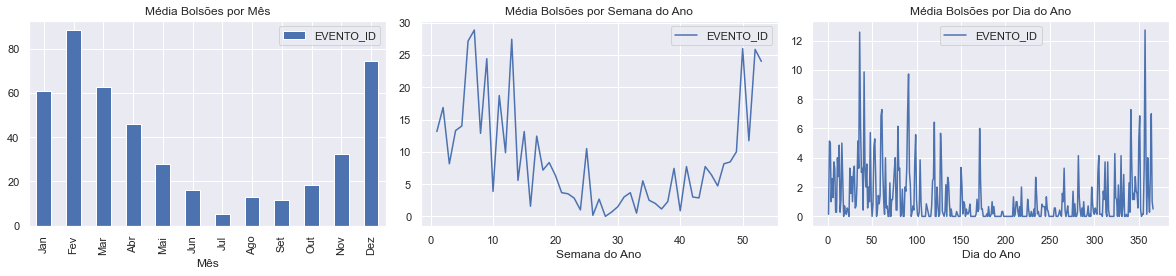

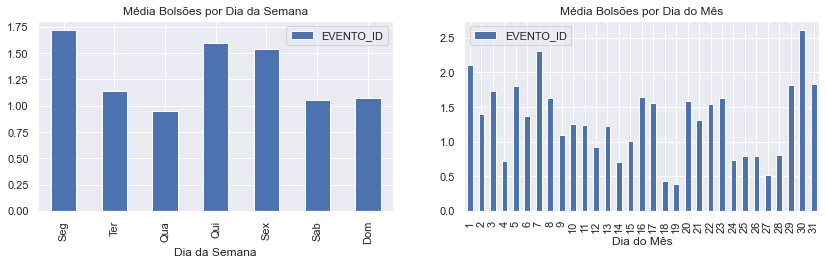

In [19]:
months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
weeks = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom']

def index_period(index, period):
    if period=='M': return index.month
    elif period=='W': return index.week
    elif period=='D': return index.dayofyear

fig, ax = plt.subplots(1, 3, figsize=(16.5, 4), tight_layout=True)

for i, freq, name in zip(
    [0, 1, 2],
    ['M', 'W', 'D'],
    ['Mês', 'Semana do Ano', 'Dia do Ano']
):
    freq_cnt = ts.resample(freq).count()[['EVENTO_ID']]
    freq_cnt[name] = index_period(freq_cnt.index, freq)
    freq_avg = freq_cnt.groupby(name).mean()
    if freq in ['D', 'W']:
        freq_avg.plot(ax=ax[i])
    else:
        freq_avg.plot.bar(ax=ax[i])
    ax[i].set(title=f'Média Bolsões por {name}')
    if freq=='M':
        ax[i].set(xticklabels=months)

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 3.5))

name = 'Dia da Semana'
freq_cnt = ts.resample('D').count()[['EVENTO_ID']]
freq_cnt[name] = freq_cnt.index.weekday
freq_cnt.groupby(name).mean().plot.bar(title=f'Média Bolsões por {name}', ax=ax[0])
ax[0].set(xticklabels=weeks)

name = 'Dia do Mês'
freq_cnt = ts.resample('D').count()[['EVENTO_ID']]
freq_cnt[name] = freq_cnt.index.day
freq_cnt.groupby(name).mean().plot.bar(title=f'Média Bolsões por {name}', ax=ax[1])

plt.show()

Obs:
1. First three periods' averages show high correlation with the incident ocorrence
2. Last two periods' averages show low correlation with the incident ocorrence